## Paso 0: Instalo las dependencias

In [392]:
#!pip install cplex docplex

In [393]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.manifold import MDS
import string

#Cplex en python
from docplex.mp.model import Model
import docplex.mp.solution as Solution

## Paso 1: Obtengo la información de los bancos

### Obtengo las distancias entre bancos

In [394]:
distances = pd.read_csv('distancias.csv', header=None)
banks = ['0'] + list(string.ascii_uppercase)[:len(distances)-1]
distances.columns = banks
distances.columns 
distances.index = banks
distances

,0,A,B,C,D,E,F,G,H,I,J
0,0,80,88,19,30,43,21,58,87,83,7
A,80,0,32,14,3,88,92,55,18,42,70
B,88,32,0,92,3,11,46,28,43,75,64
C,19,14,92,0,91,42,23,100,41,38,35
D,30,3,3,91,0,41,31,35,18,94,84
E,43,88,11,42,41,0,79,66,22,48,61
F,21,92,46,23,31,79,0,85,32,93,84
G,58,55,28,100,35,66,85,0,90,100,13
H,87,18,43,41,18,22,32,90,0,42,70
I,83,42,75,38,94,48,93,100,42,0,60


### Obtengo la ganancia/ perdida que da cada banco

In [395]:
capital = pd.read_csv('ganancias.csv', header=None)
capital.index = banks[1:]
capital

,0
A,20
B,-30
C,40
D,15
E,-20
F,-25
G,10
H,-20
I,20
J,5


Seteo MAX_DINERO a un numero arbitriario y M a un numero grande

In [396]:
MAX_DINERO = int(capital.max()*1.5)
MAX_DINERO

60

In [397]:
M = int(capital.abs().sum())
M

205

## Paso 2: Grafico la posición relativa de los bancos usando el algoritmo MDS

Esta representación no es perfecta ya que las distancias
son inventadas por lo que hay inconsistencias.

In [398]:
# Perform MDS to estimate the positions of the banks
mds = MDS(n_components=2, dissimilarity='precomputed')
positions = mds.fit_transform(distances)

# Print the estimated positions of the banks
dist = dict()

for i in range(distances.shape[0]):
  label = distances.index[i]
  x = positions[i,0]
  y = positions[i,1]
  dist[label] = (x, y)

dist

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


{'0': (28.36669471170986, 26.262931186265032),
 'A': (-31.915535425443586, -17.273595242309632),
 'B': (-32.29488994677854, 5.551526614190825),
 'C': (33.60999908607517, -11.833943569933483),
 'D': (-27.799449822491535, 2.5804078828184056),
 'E': (1.6345118375337784, -15.072234409831923),
 'F': (40.466966372246944, 6.626803617628516),
 'G': (-26.221716556460525, 44.369799460120035),
 'H': (-10.429790967433599, -27.259646630020974),
 'I': (13.615486263574894, -53.7499546468642),
 'J': (10.967724447467171, 39.797905737937405)}

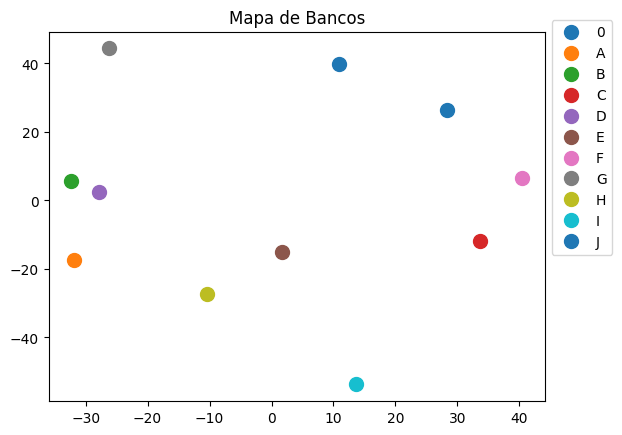

In [399]:
# Create a plot
fig, ax = plt.subplots()

# Plot the banks as dots
for bank in dist:
    ax.plot(dist[bank][0], dist[bank][1], 'o', markersize=10, label=bank)

# Add the legend
ax.legend(bbox_to_anchor=(1.15, 1.05))

# Add the title
plt.title("Mapa de Bancos")

# Show the plot
plt.show()

## Paso 3: Creo el modelo

In [400]:
model = Model('TSP', log_output=True)

### Variables

In [401]:
def U_name(key):
  return "U_" + banks[key]

In [402]:
U = model.continuous_var_list(range(1, len(banks)), 1, len(banks)-1, name=U_name)

In [403]:
Yij_duplas = [(i, j) for i in banks for j in banks if i != j]
Yij = model.binary_var_dict(Yij_duplas, name='Y')

Método 2

In [404]:
Vij_duplas = [(i, j) for i in banks[1:] for j in range(1, len(banks)) if i != j]

In [405]:
Vij = model.binary_var_dict(Vij_duplas, name="V")

Ti

In [406]:
def T_name(key):
  return "T_" + banks[key]

In [407]:
Ti = model.continuous_var_list(range(0, len(banks)), 0, MAX_DINERO, name=T_name)

### Subject to

In [408]:
for b in banks:
  model.add_constraint(model.sum(Yij[(i, j)] for i,j in Yij_duplas if i == b) == 1, ctname=f"sumatoriaSalidaDa1_{b}")

In [409]:
for b in banks:
  model.add_constraint(model.sum(Yij[(i, j)] for i,j in Yij_duplas if j == b) == 1, ctname=f"sumatoriaEntradaDa1_{b}")

In [410]:
N = len(banks)-1

In [411]:
for i in range(0, N):
  for j in range(0, N):
    if (i == j): continue
    model.add_constraint(U[i] - U[j] + N * Yij[(banks[i+1],banks[j+1])] <= N - 1, \
                         'U_' + banks[i+1] + '_'+ banks[j+1])

Metodo 2

$Uc = 1*Vc,1 + 2*Vc,2 .... +10*Vc,10$

In [412]:
U

[docplex.mp.Var(type=C,name='U_A',lb=1,ub=10),
 docplex.mp.Var(type=C,name='U_B',lb=1,ub=10),
 docplex.mp.Var(type=C,name='U_C',lb=1,ub=10),
 docplex.mp.Var(type=C,name='U_D',lb=1,ub=10),
 docplex.mp.Var(type=C,name='U_E',lb=1,ub=10),
 docplex.mp.Var(type=C,name='U_F',lb=1,ub=10),
 docplex.mp.Var(type=C,name='U_G',lb=1,ub=10),
 docplex.mp.Var(type=C,name='U_H',lb=1,ub=10),
 docplex.mp.Var(type=C,name='U_I',lb=1,ub=10),
 docplex.mp.Var(type=C,name='U_J',lb=1,ub=10)]

In [413]:
for i in range(1, len(banks)):
  rest = model.add_constraint(
      U[i-1] == sum(j * Vij[(banks[i], j)] for j in range(1, len(U) + 1))
  )

In [414]:
rest

docplex.mp.LinearConstraint[](U_J,EQ,V_J_1+2V_J_2+3V_J_3+4V_J_4+5V_J_5+6V_J_6+7V_J_7+8V_J_8+9V_J_9+10V_J_10)

$ \sum_{j=1}^{N} {Vij=1} \;\;\; \forall{i = 1,...,N} $

In [415]:
for i in banks[1:]:
  model.add_constraint(
      sum(Vij[(i, j)] for j in range(1, len(U) + 1)) == 1
  )

#### Para Ti
for i in range(1, len(U) + 1): \
model.add_constraint(T[i - 1] + sum(cte[j] * V[j][i] for j in bancos) == T[i])

In [416]:
for i in range(1, len(U) + 1):
  model.add_constraint(Ti[i - 1] + sum(int(capital.loc[j]) * Vij[(j, i)] for j in banks[1:]) == Ti[i])

In [417]:
model.add_constraint(Ti[0] == 0)

docplex.mp.LinearConstraint[](T_0,EQ,0)

### Funcional

In [418]:
model.minimize(model.sum(distances[i[0]][i[1]] * Yij[i] for i in Yij_duplas))

### Resumen del modelo

In [419]:
print(model.statistics)

 - number of variables: 231
   - binary=210, integer=0, continuous=21
 - number of constraints: 143
   - linear=143


In [420]:
print(model.export_to_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: TSP

Minimize
 obj: 80 Y_0_A + 88 Y_0_B + 19 Y_0_C + 30 Y_0_D + 43 Y_0_E + 21 Y_0_F + 58 Y_0_G
      + 87 Y_0_H + 83 Y_0_I + 7 Y_0_J + 80 Y_A_0 + 32 Y_A_B + 14 Y_A_C + 3 Y_A_D
      + 88 Y_A_E + 92 Y_A_F + 55 Y_A_G + 18 Y_A_H + 42 Y_A_I + 70 Y_A_J
      + 88 Y_B_0 + 32 Y_B_A + 92 Y_B_C + 3 Y_B_D + 11 Y_B_E + 46 Y_B_F
      + 28 Y_B_G + 43 Y_B_H + 75 Y_B_I + 64 Y_B_J + 19 Y_C_0 + 14 Y_C_A
      + 92 Y_C_B + 91 Y_C_D + 42 Y_C_E + 23 Y_C_F + 100 Y_C_G + 41 Y_C_H
      + 38 Y_C_I + 35 Y_C_J + 30 Y_D_0 + 3 Y_D_A + 3 Y_D_B + 91 Y_D_C + 41 Y_D_E
      + 31 Y_D_F + 35 Y_D_G + 18 Y_D_H + 94 Y_D_I + 84 Y_D_J + 43 Y_E_0
      + 88 Y_E_A + 11 Y_E_B + 42 Y_E_C + 41 Y_E_D + 79 Y_E_F + 66 Y_E_G
      + 22 Y_E_H + 48 Y_E_I + 61 Y_E_J + 21 Y_F_0 + 92 Y_F_A + 46 Y_F_B
      + 23 Y_F_C + 31 Y_F_D + 79 Y_F_E + 85 Y_F_G + 32 Y_F_H + 93 Y_F_I
      + 84 Y_F_J + 58 Y_G_0 + 55 Y_G_A + 28 Y_G_B + 100 Y_G_C + 35 Y_G_D
      + 66 Y_G_

## Paso 4: Resuelvo con CPLEX

In [421]:
solution = model.solve()

Version identifier: 22.1.1.0 | 2023-02-11 | 22d6266e5
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
MIP Presolve eliminated 1 rows and 1 columns.
MIP Presolve modified 100 coefficients.
Reduced MIP has 142 rows, 230 columns, and 809 nonzeros.
Reduced MIP has 210 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (0.68 ticks)
Probing fixed 4 vars, tightened 0 bounds.
Probing time = 0.00 sec. (0.51 ticks)
Cover probing fixed 0 vars, tightened 4 bounds.
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve eliminated 0 rows and 4 columns.
MIP Presolve modified 108 coefficients.
Reduced MIP has 142 rows, 226 columns, and 797 nonzeros.
Reduced MIP has 206 binaries, 20 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.77 ticks)
Probing time = 0.00 sec. (0.57 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Clique table members: 477.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic se

In [422]:
model.get_solve_status() # 2 = TODO OK

<JobSolveStatus.OPTIMAL_SOLUTION: 2>

In [423]:
solution.get_objective_value()

243.0

In [424]:
final_values = solution.as_df()
final_values

,name,value
0,U_A,4.0
1,U_B,8.0
2,U_C,1.0
3,U_D,3.0
4,U_E,7.0
5,U_F,2.0
6,U_G,9.0
7,U_H,5.0
8,U_I,6.0
9,U_J,10.0


In [425]:
nombres_bancos= [
  'Banco Porteño',
  'Banco Del Plata',
  'Banco De Los Andes',
  'Banco Plural',
  'Banco Del Norte',
  'Banco Pampeano',
  'Banco Cooperativo',
  'Banco Sol',
  'Banco República',
  'Banco Vientos del Sur',
]

In [426]:
orden = final_values.iloc[0:N]
orden.name = nombres_bancos
orden.sort_values(by="value", inplace=True)
orden

<ipython-input-426-c8d1485eef02>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orden.name = nombres_bancos
<ipython-input-426-c8d1485eef02>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orden.sort_values(by="value", inplace=True)


,name,value
2,Banco De Los Andes,1.0
5,Banco Pampeano,2.0
3,Banco Plural,3.0
0,Banco Porteño,4.0
7,Banco Sol,5.0
8,Banco República,6.0
4,Banco Del Norte,7.0
1,Banco Del Plata,8.0
6,Banco Cooperativo,9.0
9,Banco Vientos del Sur,10.0


## Paso 5: Grafico la solución

Creo las conexiones

In [427]:
final_values.iloc[N-1:2*N-1]

,name,value
9,U_J,10.0
10,Y_0_C,1.0
11,Y_A_H,1.0
12,Y_B_G,1.0
13,Y_C_F,1.0
14,Y_D_A,1.0
15,Y_E_B,1.0
16,Y_F_D,1.0
17,Y_G_J,1.0
18,Y_H_I,1.0


In [428]:
def obtener_bancos(row):
  bancos = row["name"].split("_")
  return bancos[1], bancos[2]

In [429]:
# Define the connections between the banks
# Sería el recorrido del camión
connections = final_values.iloc[N:2*N+1]
connections = connections.apply(obtener_bancos, axis=1)
connections = list(connections)
connections

[('0', 'C'),
 ('A', 'H'),
 ('B', 'G'),
 ('C', 'F'),
 ('D', 'A'),
 ('E', 'B'),
 ('F', 'D'),
 ('G', 'J'),
 ('H', 'I'),
 ('I', 'E'),
 ('J', '0')]

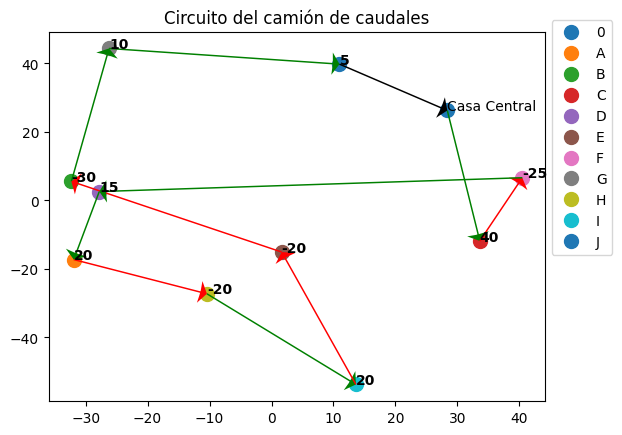

In [430]:
casa_central = banks[0]

# Create a plot
fig, ax = plt.subplots()

# Plot the banks as dots
for bank in dist:
    ax.plot(dist[bank][0], dist[bank][1], 'o', markersize=10, label=bank)

# Plot the connections as arrows
for connection in connections:
  x1, y1 = dist[connection[0]]
  x2, y2 = dist[connection[1]]
  dx, dy = x2 - x1, y2 - y1
  
  if connection[1] == casa_central:
    color = 'black'
  else:
    cambio = int(capital.loc[connection[1]])
    if cambio > 0:
      color = 'green'
    else:
      color = 'red'
  
  ax.quiver(x1, y1, dx, dy,
            angles='xy', scale_units='xy',
            scale=1, width=0.003,
            headwidth=15, color=color,
            zorder=3)

# Annotate the Casa Central
ax.annotate('Casa Central', dist[casa_central])

# Annotate the capital
for b in banks[1:]:
  ax.annotate(int(capital.loc[b]), dist[b], weight="bold")

# Add the legend
ax.legend(bbox_to_anchor=(1.15, 1.05))

# Add the title
plt.title("Circuito del camión de caudales")

# Show the plot
plt.show()